# Working with Custom Images

## The Data

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

In [39]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Visualizing the Data

In [2]:
filepath = '/home/dhrumpy/Videos/cell_images/'
train_path = filepath + 'train/'
test_path = filepath + 'test/'

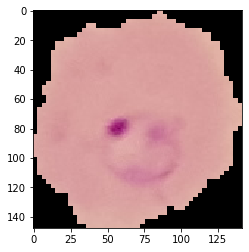

In [3]:
img = imread(train_path+'parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
plt.imshow(img);

In [4]:
# files in a directory
os.listdir(filepath)

['test', 'train']

In [5]:
os.listdir(train_path), os.listdir(test_path)

(['parasitized', 'uninfected'], ['parasitized', 'uninfected'])

In [6]:
# grabbing the firstimage
os.listdir(train_path+'uninfected')[0]

'C187P148NThinF_IMG_20151203_153410_cell_70.png'

In [7]:
img = imread(train_path+'uninfected/C187P148NThinF_IMG_20151203_153410_cell_70.png')
img.shape

(112, 115, 3)

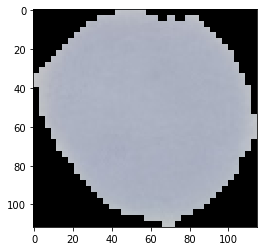

In [8]:
plt.imshow(img)

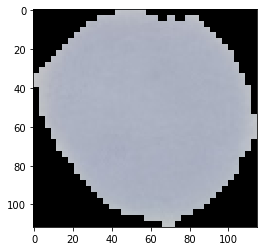

In [9]:
img = imread(train_path+'uninfected/C187P148NThinF_IMG_20151203_153410_cell_70.png')
plt.imshow(img)

# Preparing the Data for the model

In [10]:
img.shape

(112, 115, 3)

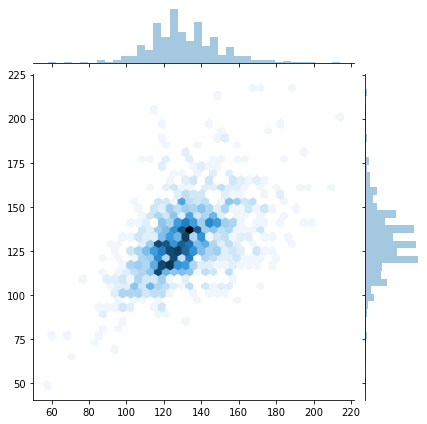

In [11]:
# iterating through (say test folder and finding out the dimensions of the images)
dim1, dim2 = [], []
for img_filename in os.listdir(test_path+'uninfected'):
    img = imread(test_path+'uninfected/'+img_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)
    
sns.jointplot(dim1, dim2, kind='hex')

In [12]:
np.mean(dim1), np.mean(dim2) # we resize all the images to this dimension

(130.92538461538462, 130.75)

In [13]:
img_shape = (130, 130, 3)

In [14]:
# Image manipulation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
help(ImageDataGenerator)

Help on class ImageDataGenerator in module tensorflow.python.keras.preprocessing.image:

class ImageDataGenerator(keras_preprocessing.image.image_data_generator.ImageDataGenerator)
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |   The data will be looped over (in batches).
 |  
 |  Arguments:
 |      featurewise_center: Boolean.
 |          Set input mean to 0 over the dataset, feature-wise.
 |      samplewise_center: Boolean. Set each sample mean to 0.
 |      featurewise_std_normalization: Boolean.
 |          Divide inputs by std of the dataset, feature-wise.
 |      samplewise_std_normalization: Boolean. Divide each input by its std.
 |      zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
 |      zca_whitening: Boolean. Apply ZCA whitening.
 |      rotation_range: Int. Degree range for random rotations.
 |      width_shift_range: Float, 1-D array-like or int
 |          - float: fraction of total width, if < 1, or pixels if >= 1.
 |     

In [15]:
img_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                            height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
                            horizontal_flip=True, fill_mode='nearest')

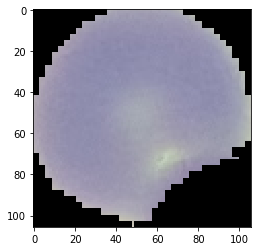

In [16]:
plt.imshow(img)

In [17]:
img.max()

0.8156863

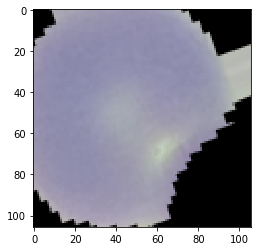

In [18]:
plt.imshow(img_gen.random_transform(img))

In [19]:
# flow batches from directory
img_gen.flow_from_directory(train_path) 
# this requires file to be organized in a very specific way 
# (subdirectories, one folder per class)

Found 24958 images belonging to 2 classes.


In [20]:
img_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Building the Model

In [21]:
# Creating a model: fitting to a generator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

from tensorflow.keras.callbacks import EarlyStopping

In [22]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=img_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [23]:
batch_size=16
train_img_gen = img_gen.flow_from_directory(train_path, target_size=img_shape[:2],
                                           color_mode='rgb', batch_size=batch_size,
                                           class_mode='binary')
test_img_gen = img_gen.flow_from_directory(test_path, target_size=img_shape[:2],
                                           color_mode='rgb', batch_size=batch_size,
                                           class_mode='binary', shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [24]:
train_img_gen.class_indices, test_img_gen.class_indices

({'parasitized': 0, 'uninfected': 1}, {'parasitized': 0, 'uninfected': 1})

In [25]:
# resulting model
# import PIL

result = model.fit_generator(train_img_gen, epochs=20, validation_data=test_img_gen,
                            callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1560 steps, validate for 163 steps
Epoch 1/20
1560/1560 [==============================] - 828s 531ms/step - loss: 0.8441 - accuracy: 0.5389 - val_loss: 0.6818 - val_accuracy: 0.5646
Epoch 2/20
1560/1560 [==============================] - 912s 585ms/step - loss: 0.6939 - accuracy: 0.5571 - val_loss: 0.7115 - val_accuracy: 0.5427
Epoch 3/20
1560/1560 [==============================] - 923s 591ms/step - loss: 0.6785 - accuracy: 0.5771 - val_loss: 0.6744 - val_accuracy: 0.5873
Epoch 4/20
1560/1560 [==============================] - 839s 538ms/step - loss: 0.6706 - accuracy: 0.5959 - val_loss: 0.6626 - val_accuracy: 0.6192
Epoch 5/20
1560/1560 [==============================] - 794s 509ms/step - loss: 0.6666 - accuracy: 0.6087 - val_loss: 0.6621 - val_accuracy: 0.6192
Epoch 6/20
1560/1560 [==============================] - 901s 578ms/step - loss: 0.5921 - 

In [27]:
metrics = pd.DataFrame(model.history.history)

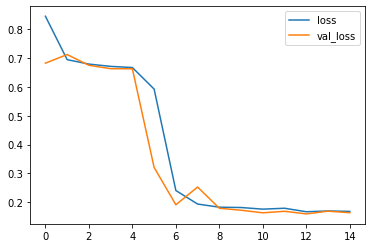

In [30]:
metrics[['loss', 'val_loss']].plot()

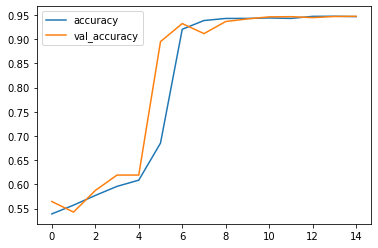

In [31]:
metrics[['accuracy', 'val_accuracy']].plot()

In [32]:
from tensorflow.keras.models import load_model
model.save('malaria-01.h5')  

In [38]:
metrics.to_csv('malaria_modelHistory.csv')

# Evaluating the Model

In [42]:
model.evaluate(train_img_gen)

In [45]:
model.metrics_names

['loss', 'accuracy']

In [47]:
pred = model.predict_generator(test_img_gen)
pred # probabilities

array([[2.2867305e-05],
       [1.4623399e-04],
       [6.0166360e-04],
       ...,
       [9.4874781e-01],
       [9.7375816e-01],
       [9.3229491e-01]], dtype=float32)

In [48]:
predictions = pred>0.5
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_img_gen.classes, predictions))
print(confusion_matrix(test_img_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1300
           1       0.93      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600

[[1204   96]
 [  46 1254]]


In [60]:
# os.listdir(test_path+'parasitized')

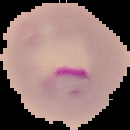

In [66]:
# predicting on a single image
# img = imread(test_path+'parasitized/C39P4thinF_original_IMG_20150622_110435_cell_113.png')
# or use the alternative to read images, using tensorflow

from tensorflow.keras.preprocessing import image
test_image = image.load_img(test_path+'parasitized/C39P4thinF_original_IMG_20150622_110435_cell_113.png',
              target_size=img_shape)

test_image

In [71]:
test_img_arr = image.img_to_array(test_image)
test_img_arr.shape

(130, 130, 3)

In [73]:
test_img_arr = test_img_arr[np.newaxis,:,:,:]
test_img_arr.shape

(1, 130, 130, 3)

In [76]:
# predicting off a single image not generator
model.predict(test_img_arr)

array([[0.00485648]], dtype=float32)

In [78]:
train_img_gen.class_indices

{'parasitized': 0, 'uninfected': 1}